# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings
from transformers import AutoTokenizer
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.utils.average_meter import AverageMeter
from lib.data_tools.data import collate
from lib.model.inference import ensemble_inference
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=2,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          lgbm_a=2.998,
          lgbm_b=1.092,
          lgbm_n_folds=15,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=5,
          negative_sample=True,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          regression=False,
          scheduler='cosine',
          stride=192,
          tokenizer_ve

In [5]:
seed_everything()

In [6]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Setting Up WandB

In [7]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [8]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [10]:
class_weights = torch.tensor([1.0] * 6).to(device)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(Paths.TOKENIZER_PATH)
vocabulary = tokenizer.get_vocab()
total_tokens = len(vocabulary)
print("Total number of tokens in the tokenizer:", total_tokens)
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of tokens in the tokenizer: 128003
DebertaV2TokenizerFast(name_or_path='output/microsoft/deberta-v3-xsmall/tokenizer_v2', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized

In [12]:
root_data_dir = "data/lgbm_deberta"

### 🛠️ Functions

In [13]:
def read_data_for_path(fold, part):
    fold_path = os.path.join(root_data_dir, f"fold_{fold}")
    part_path = os.path.join(fold_path, f"part_{part}")

    train_loader = torch.load(os.path.join(part_path, f"train_{fold}_{part}.pth"))
    valid_loader = torch.load(os.path.join(part_path, f"valid_{fold}_{part}.pth"))
    valid_csv = pd.read_csv(os.path.join(part_path, f"valid_{fold}_{part}.csv"), usecols=["score"])

    return train_loader, valid_loader, valid_csv.values

In [14]:
def get_input_and_labels(batch):
    inputs = collate(batch.pop("inputs"))
    labels = batch.pop("labels")

    for k, v in inputs.items():  # send each tensor value to `device`
        inputs[k] = v.to(device)

    labels = labels.to(device)  # send labels to `device`

    return inputs, labels

In [15]:
def grad_step(step, scaler, model, optimizer, scheduler, labels, losses, loss):
    if config.gradient_accumulation_steps > 1:
        loss = loss / config.gradient_accumulation_steps

    losses.update(loss.item(), labels.size(0))  # update loss function tracking
    scaler.scale(loss).backward()  # backward propagation pass
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

    if (step + 1) % config.gradient_accumulation_steps == 0:
        scaler.step(optimizer)  # update optimizer parameters
        scaler.update()
        optimizer.zero_grad()  # zero out the gradients

        if config.batch_scheduler:
            scheduler.step()  # update learning rate

    return grad_norm

In [16]:
def log_metrics_training(
    fold,
    part,
    train_loader,
    epoch,
    scheduler,
    losses,
    n_steps_per_epoch,
    step,
    grad_norm,
):
    if step % config.print_freq == 0 or step == (len(train_loader) - 1):
        wandb.log(
            {
                f"train/epoch_f{fold}_p{part}": (step + 1 + (n_steps_per_epoch * epoch))
                / n_steps_per_epoch,
                f"train/train_loss_f{fold}_p{part}": losses.avg,
                f"train/grad_norm_f{fold}_p{part}": grad_norm,
                f"train/learning_rate_f{fold}_p{part}": scheduler.get_lr()[0],
            }
        )

In [17]:
def train_epoch(
    fold,
    part,
    train_loader,
    model,
    criterion,
    optimizer,
    epoch,
    scheduler,
):
    """One epoch training pass.

    Source:
    https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=26
    """
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    losses = AverageMeter()  # initiate AverageMeter to track the loss.
    n_steps_per_epoch = math.ceil(len(train_loader) / config.batch_size_train)

    with tqdm(
        train_loader,
        unit="train_batch",
        desc=f"Training Fold {fold} Part {part}",
    ) as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs, labels = get_input_and_labels(batch)

            with torch.cuda.amp.autocast(enabled=config.apex):
                y_preds = model(inputs)
                loss = criterion(y_preds, labels)

            grad_norm = grad_step(step, scaler, model, optimizer, scheduler, labels, losses, loss)

            log_metrics_training(
                fold,
                part,
                train_loader,
                epoch,
                scheduler,
                losses,
                n_steps_per_epoch,
                step,
                grad_norm,
            )

    return losses.avg

In [18]:
def valid_epoch(fold, part, epoch, valid_loader, model, criterion, valid_labels):
    model.eval()
    losses = AverageMeter()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    ids = []

    with tqdm(
        valid_loader,
        unit="valid_batch",
        desc=f"Validating Fold {fold} Part {part}",
    ) as tqdm_valid_loader:
        for _, batch in enumerate(tqdm_valid_loader):
            essay_ids = batch.pop("essay_ids")
            inputs, labels = get_input_and_labels(batch)

            with torch.no_grad():
                y_preds = model(inputs)
                loss = criterion(y_preds, labels)

            if config.gradient_accumulation_steps > 1:
                loss = loss / config.gradient_accumulation_steps

            losses.update(loss.item(), labels.size(0))
            preds.append(y_preds.to("cpu").numpy())
            ids.append(essay_ids)

    prediction_dict["predictions"] = softmax(torch.tensor(np.concatenate(preds)))
    prediction_dict["essay_id"] = np.concatenate(ids)

    _, predictions = torch.max(prediction_dict["predictions"], dim=1)

    score = get_score(valid_labels, predictions)

    wandb.log(
        {
            f"eval/eval_epoch_f{fold}_p{part}": epoch + 1,
            f"eval/eval_loss_f{fold}_p{part}": losses.avg,
            f"eval/qwk_score_f{fold}_p{part}": score,
        }
    )

    return losses.avg, score, prediction_dict

In [19]:
def get_model_save_path(fold, part):
    model_name = f"{config.model.replace('/', '_')}_fold_{fold}_part_{part}.pth"
    model_fold_path = os.path.join(Paths.MODEL_OUTPUT_PATH, f"fold_{fold}")

    if not os.path.exists(model_fold_path):
        os.makedirs(model_fold_path)

    model_save_path = os.path.join(model_fold_path, model_name)
    return model_save_path

In [20]:
def train_model_part(fold, part):
    train_loader, valid_loader, valid_labels = read_data_for_path(fold, part)
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    best_score = -np.inf

    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            part,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
        )

        # ======= EVALUATION ==========
        avg_val_loss, score, prediction_dict = valid_epoch(
            fold,
            part,
            epoch,
            valid_loader,
            model,
            criterion,
            valid_labels,
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - "
            + f"avg_train_loss: {avg_loss:.4f} "
            + f"avg_val_loss: {avg_val_loss:.4f} "
            + f"time: {elapsed:.0f}s "
            + f"Score: {score:.4f}"
        )

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save({"model": model.state_dict()}, get_model_save_path(fold, part))

    del model, optimizer, scheduler, criterion
    torch.cuda.empty_cache()
    gc.collect()

    return prediction_dict

In [21]:
def evaluate_group(fold, valid_fold, valid_labels, model_paths):
    predictions = ensemble_inference(
        valid_fold,
        tokenizer,
        model_paths,
        device,
        overall=True,
        logits=True,
    )
    score = get_score(valid_labels, predictions["score"])

    wandb.log(
        {
            f"eval/eval_epoch_f{fold}": config.epochs,
            f"eval/qwk_score_f{fold}": score,
        }
    )
    return predictions

In [22]:
def parse_prediction_dict(predictions):
    temp = {"essay_id": predictions["essay_id"]}

    for i in range(predictions["predictions"].shape[1]):
        temp[f"score_prob_{i}"] = predictions["predictions"][:, i]

    temp = pd.DataFrame(temp)
    return temp

In [23]:
def train_all_parts(fold):
    model_paths = {
        os.path.join(
            Paths.MODEL_OUTPUT_PATH,
            f"fold_{fold}/{config.model.replace('/', '_')}_fold_{fold}_part_{part}.pth",
        ): 1
        for part in range(config.n_folds)
    }

    train_oof_df = pd.DataFrame()
    for part in range(config.n_folds):
        prediction_dict = train_model_part(fold, part)
        predictions = parse_prediction_dict(prediction_dict)
        train_oof_df = pd.concat([train_oof_df, predictions])

    train_oof_df.to_csv(
        os.path.join(root_data_dir, f"fold_{fold}/oof_train_{fold}.csv"),
        index=False,
    )

    valid_fold = pd.read_csv(
        os.path.join(root_data_dir, f"fold_{fold}/valid_{fold}.csv")
    )
    valid_labels = valid_fold["score"].values

    group_pred = evaluate_group(fold, valid_fold, valid_labels, model_paths)
    valid_fold["pred_score"] = group_pred["score"]
    
    group_pred.to_csv(
        os.path.join(root_data_dir, f"fold_{fold}/oof_valid_{fold}.csv"),
        index=False,
    )

    return valid_fold

In [24]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [25]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_all_parts(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv("data/lgbm_deberta/oof_df.csv", index=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.2247 avg_val_loss: 0.9967 time: 160s Score: 0.7580
Epoch 1 - Save Best Score: 0.7580 Model


Validating Fold 0 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9718 avg_val_loss: 0.9784 time: 161s Score: 0.7482


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 1: 100%|██████████| 121/121 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.2181 avg_val_loss: 1.0430 time: 161s Score: 0.7351
Epoch 1 - Save Best Score: 0.7351 Model


Validating Fold 0 Part 1: 100%|██████████| 121/121 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9570 avg_val_loss: 0.9927 time: 161s Score: 0.7548
Epoch 2 - Save Best Score: 0.7548 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2331 avg_val_loss: 1.0228 time: 161s Score: 0.7692
Epoch 1 - Save Best Score: 0.7692 Model


Validating Fold 0 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9559 avg_val_loss: 0.9430 time: 165s Score: 0.7956
Epoch 2 - Save Best Score: 0.7956 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.2343 avg_val_loss: 1.0620 time: 161s Score: 0.7729
Epoch 1 - Save Best Score: 0.7729 Model


Validating Fold 0 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.9584 avg_val_loss: 0.9496 time: 161s Score: 0.7790
Epoch 2 - Save Best Score: 0.7790 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2232 avg_val_loss: 1.1210 time: 161s Score: 0.6655
Epoch 1 - Save Best Score: 0.6655 Model


Validating Fold 0 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.9780 avg_val_loss: 1.0340 time: 161s Score: 0.7099
Epoch 2 - Save Best Score: 0.7099 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]


========== Fold: 0 result ==========
Score: 0.7602


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.1945 avg_val_loss: 1.0152 time: 161s Score: 0.7490
Epoch 1 - Save Best Score: 0.7490 Model


Validating Fold 1 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9561 avg_val_loss: 0.9394 time: 161s Score: 0.7738
Epoch 2 - Save Best Score: 0.7738 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.34valid_batch/s]


Epoch 1 - avg_train_loss: 1.2259 avg_val_loss: 1.0285 time: 165s Score: 0.7558
Epoch 1 - Save Best Score: 0.7558 Model


Validating Fold 1 Part 1: 100%|██████████| 119/119 [00:20<00:00,  5.95valid_batch/s]


Epoch 2 - avg_train_loss: 0.9633 avg_val_loss: 0.9754 time: 177s Score: 0.7609
Epoch 2 - Save Best Score: 0.7609 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 2: 100%|██████████| 119/119 [00:19<00:00,  5.99valid_batch/s]


Epoch 1 - avg_train_loss: 1.2036 avg_val_loss: 1.0815 time: 177s Score: 0.6991
Epoch 1 - Save Best Score: 0.6991 Model


Validating Fold 1 Part 2: 100%|██████████| 119/119 [00:19<00:00,  6.03valid_batch/s]


Epoch 2 - avg_train_loss: 0.9578 avg_val_loss: 0.9802 time: 177s Score: 0.7543
Epoch 2 - Save Best Score: 0.7543 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 3: 100%|██████████| 118/118 [00:19<00:00,  6.01valid_batch/s]


Epoch 1 - avg_train_loss: 1.2194 avg_val_loss: 1.0041 time: 177s Score: 0.7211
Epoch 1 - Save Best Score: 0.7211 Model


Validating Fold 1 Part 3: 100%|██████████| 118/118 [00:19<00:00,  5.98valid_batch/s]


Epoch 2 - avg_train_loss: 0.9753 avg_val_loss: 0.9535 time: 177s Score: 0.7665
Epoch 2 - Save Best Score: 0.7665 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 4: 100%|██████████| 122/122 [00:19<00:00,  6.27valid_batch/s]


Epoch 1 - avg_train_loss: 1.2287 avg_val_loss: 1.0395 time: 170s Score: 0.7206
Epoch 1 - Save Best Score: 0.7206 Model


Validating Fold 1 Part 4: 100%|██████████| 122/122 [00:19<00:00,  6.12valid_batch/s]


Epoch 2 - avg_train_loss: 0.9788 avg_val_loss: 0.9571 time: 171s Score: 0.7447
Epoch 2 - Save Best Score: 0.7447 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:19<00:00,  5.52test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.78test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.86test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.87test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.86test_batch/s]


========== Fold: 1 result ==========
Score: 0.7516


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2106 avg_val_loss: 1.0338 time: 161s Score: 0.7049
Epoch 1 - Save Best Score: 0.7049 Model


Validating Fold 2 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9600 avg_val_loss: 0.9607 time: 161s Score: 0.7833
Epoch 2 - Save Best Score: 0.7833 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.55valid_batch/s]


Epoch 1 - avg_train_loss: 1.2182 avg_val_loss: 1.0143 time: 161s Score: 0.7615
Epoch 1 - Save Best Score: 0.7615 Model


Validating Fold 2 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9634 avg_val_loss: 0.9451 time: 166s Score: 0.7690
Epoch 2 - Save Best Score: 0.7690 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 1 - avg_train_loss: 1.1998 avg_val_loss: 1.0194 time: 161s Score: 0.7205
Epoch 1 - Save Best Score: 0.7205 Model


Validating Fold 2 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9497 avg_val_loss: 0.9446 time: 161s Score: 0.7594
Epoch 2 - Save Best Score: 0.7594 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.60valid_batch/s]


Epoch 1 - avg_train_loss: 1.1915 avg_val_loss: 1.0507 time: 161s Score: 0.7572
Epoch 1 - Save Best Score: 0.7572 Model


Validating Fold 2 Part 3: 100%|██████████| 119/119 [00:19<00:00,  6.22valid_batch/s]


Epoch 2 - avg_train_loss: 0.9535 avg_val_loss: 0.9609 time: 165s Score: 0.7799
Epoch 2 - Save Best Score: 0.7799 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2295 avg_val_loss: 0.9875 time: 167s Score: 0.7866
Epoch 1 - Save Best Score: 0.7866 Model


Validating Fold 2 Part 4: 100%|██████████| 119/119 [00:19<00:00,  6.05valid_batch/s]


Epoch 2 - avg_train_loss: 0.9545 avg_val_loss: 0.9182 time: 164s Score: 0.7978
Epoch 2 - Save Best Score: 0.7978 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.33test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.38test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.40test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.38test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.40test_batch/s]


========== Fold: 2 result ==========
Score: 0.7699


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 0: 100%|██████████| 120/120 [00:19<00:00,  6.07valid_batch/s]


Epoch 1 - avg_train_loss: 1.2112 avg_val_loss: 0.9962 time: 176s Score: 0.7362
Epoch 1 - Save Best Score: 0.7362 Model


Validating Fold 3 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.35valid_batch/s]


Epoch 2 - avg_train_loss: 0.9356 avg_val_loss: 0.9594 time: 172s Score: 0.7723
Epoch 2 - Save Best Score: 0.7723 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.35valid_batch/s]


Epoch 1 - avg_train_loss: 1.2199 avg_val_loss: 1.0251 time: 165s Score: 0.7272
Epoch 1 - Save Best Score: 0.7272 Model


Validating Fold 3 Part 1: 100%|██████████| 120/120 [00:19<00:00,  6.13valid_batch/s]


Epoch 2 - avg_train_loss: 0.9756 avg_val_loss: 0.9661 time: 172s Score: 0.7775
Epoch 2 - Save Best Score: 0.7775 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 2: 100%|██████████| 119/119 [00:19<00:00,  6.17valid_batch/s]


Epoch 1 - avg_train_loss: 1.1791 avg_val_loss: 0.9770 time: 173s Score: 0.7551
Epoch 1 - Save Best Score: 0.7551 Model


Validating Fold 3 Part 2: 100%|██████████| 119/119 [00:19<00:00,  6.01valid_batch/s]


Epoch 2 - avg_train_loss: 0.9807 avg_val_loss: 0.9341 time: 175s Score: 0.7972
Epoch 2 - Save Best Score: 0.7972 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.1889 avg_val_loss: 1.0525 time: 166s Score: 0.7582
Epoch 1 - Save Best Score: 0.7582 Model


Validating Fold 3 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9575 avg_val_loss: 0.9442 time: 162s Score: 0.7837
Epoch 2 - Save Best Score: 0.7837 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.1777 avg_val_loss: 1.0272 time: 162s Score: 0.7667
Epoch 1 - Save Best Score: 0.7667 Model


Validating Fold 3 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9718 avg_val_loss: 0.9762 time: 162s Score: 0.7678
Epoch 2 - Save Best Score: 0.7678 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]


========== Fold: 3 result ==========
Score: 0.7813


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 0: 100%|██████████| 121/121 [00:18<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.2120 avg_val_loss: 1.0122 time: 161s Score: 0.7520
Epoch 1 - Save Best Score: 0.7520 Model


Validating Fold 4 Part 0: 100%|██████████| 121/121 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9634 avg_val_loss: 0.9702 time: 161s Score: 0.7710
Epoch 2 - Save Best Score: 0.7710 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.54valid_batch/s]


Epoch 1 - avg_train_loss: 1.2176 avg_val_loss: 1.0097 time: 161s Score: 0.7612
Epoch 1 - Save Best Score: 0.7612 Model


Validating Fold 4 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9728 avg_val_loss: 0.9988 time: 161s Score: 0.7267


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2169 avg_val_loss: 1.0739 time: 161s Score: 0.6817
Epoch 1 - Save Best Score: 0.6817 Model


Validating Fold 4 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9886 avg_val_loss: 0.9861 time: 161s Score: 0.7593
Epoch 2 - Save Best Score: 0.7593 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2178 avg_val_loss: 1.0470 time: 161s Score: 0.7257
Epoch 1 - Save Best Score: 0.7257 Model


Validating Fold 4 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9573 avg_val_loss: 0.9503 time: 161s Score: 0.7715
Epoch 2 - Save Best Score: 0.7715 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.1938 avg_val_loss: 1.0612 time: 161s Score: 0.7261
Epoch 1 - Save Best Score: 0.7261 Model


Validating Fold 4 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9738 avg_val_loss: 0.9694 time: 161s Score: 0.7728
Epoch 2 - Save Best Score: 0.7728 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]


========== Fold: 4 result ==========
Score: 0.7611
========== CV ==========
Score: 0.7650


In [26]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [27]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

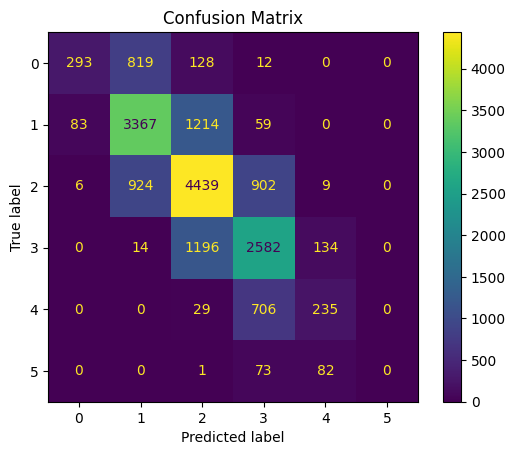

In [28]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [29]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁
eval/eval_epoch_f0_p0,▁█
eval/eval_epoch_f0_p1,▁█
eval/eval_epoch_f0_p2,▁█
eval/eval_epoch_f0_p3,▁█
eval/eval_epoch_f0_p4,▁█
eval/eval_epoch_f1,▁
eval/eval_epoch_f1_p0,▁█
eval/eval_epoch_f1_p1,▁█
eval/eval_epoch_f1_p2,▁█
